# **Pre/Post COVID Flight Analysis Prediction Model**
### **By:** Mariah N Cornelio
- **Goal:** Predict flight risk (delays is less than or equal to 15 min or cancellations) by airline, airport, and month
- **Nuance:** COVID era causes unusual patterns; include as a feature to avoid skewing predictions
- **Model:** Supervised learning → binary classification (high-risk vs low-risk); must also take out risk score as a feature to prevent data leakage
- **Purpose:** Although risk score was calculated using weights in SQL, this predictive model goes beyond the historical SQL risk score by forecasting future flight risk based on patterns and trends, rather than just summarizing past data
- **Data:** https://transtats.bts.gov/OT_Delay/OT_DelayCause1.asp
- **KPIs:** Use aggregated KPIs #1–#6 (flight counts, on-time %, avg delay, delay causes, cancellation rate, risk score) as features

### **OVERVIEW**
- **Part 1:** Create SQL database from raw data
- **Part 2:** Work on KPI #1-6 on SQL and create master_kpi table from that
- **Part 3:** Extract master_kpi table from SQL and use that data to create prediction model (KPI #7)
- **Part 4:** Create dashboard using data from KPI's #1-7

**Importing packages**

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### **Part 1: Create SQL database from raw data**

In [2]:
# Turn csv into SQL database
df = pd.read_csv("Airline_Delay_Cause.csv")  
conn = sqlite3.connect("airline_data.db")
df.to_sql("flights", conn, if_exists="replace", index=False)
conn.close() # this closes the connection

### **Part 2: Work on KPI #1-6 on SQL and create master_kpi table from that**
Done on SQLite

### **Part 3: Extract master_kpi table from SQL and use that data to create prediction model KPI #7**

In [2]:
df=pd.read_csv("master_kpi.csv")

In [3]:
df.head(5)

,year,month,carrier,carrier_name,airport,airport_name,total_flights,on_time_pct,avg_delay_minutes,carrier_delay_count,...,security_delay_count,late_aircraft_delay_count,carrier_delay_minutes,weather_delay_minutes,nas_delay_minutes,security_delay_minutes,late_aircraft_delay_minutes,cancellation_rate,overall_risk_score,covid_era
0,2016,1,AA,American Airlines Inc.,ABQ,"Albuquerque, NM: Albuquerque International Sun...",148.0,0.8311,6.31,14.55,...,0.00,5.66,601.0,48.0,84.0,0.0,201.0,0.0068,0.0523,Pre-COVID
1,2016,1,AA,American Airlines Inc.,ALB,"Albany, NY: Albany International",81.0,0.8519,8.68,7.30,...,0.00,1.10,521.0,0.0,137.0,0.0,45.0,0.0617,0.0800,Pre-COVID
2,2016,1,AA,American Airlines Inc.,ANC,"Anchorage, AK: Ted Stevens Anchorage Internati...",31.0,0.9032,3.00,1.00,...,0.48,0.52,52.0,0.0,18.0,11.0,12.0,0.0000,0.0319,Pre-COVID
3,2016,1,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",833.0,0.8343,8.43,65.61,...,0.00,34.67,3799.0,322.0,847.0,0.0,2057.0,0.0252,0.0738,Pre-COVID
4,2016,1,AA,American Airlines Inc.,AUS,"Austin, TX: Austin - Bergstrom International",751.0,0.8802,6.39,41.91,...,0.00,33.38,2289.0,140.0,479.0,0.0,1892.0,0.0133,0.0575,Pre-COVID


**Inspecting data**

In [4]:
df.shape

# 207,377 rows and 22 columns

(207377, 22)

In [5]:
df.dtypes

year                             int64
month                            int64
carrier                         object
carrier_name                    object
airport                         object
airport_name                    object
total_flights                  float64
on_time_pct                    float64
avg_delay_minutes              float64
carrier_delay_count            float64
weather_delay_count            float64
nas_delay_count                float64
security_delay_count           float64
late_aircraft_delay_count      float64
carrier_delay_minutes          float64
weather_delay_minutes          float64
nas_delay_minutes              float64
security_delay_minutes         float64
late_aircraft_delay_minutes    float64
cancellation_rate              float64
overall_risk_score             float64
covid_era                       object
dtype: object

In [7]:
df.duplicated().sum() # No duplicates

np.int64(0)

In [77]:
df.isnull().sum()

year                             0
month                            0
carrier                          0
carrier_name                     0
airport                          0
airport_name                     0
total_flights                  350
on_time_pct                    607
avg_delay_minutes              350
carrier_delay_count            350
weather_delay_count            350
nas_delay_count                350
security_delay_count           350
late_aircraft_delay_count      350
carrier_delay_minutes          350
weather_delay_minutes          350
nas_delay_minutes              350
security_delay_minutes         350
late_aircraft_delay_minutes    350
cancellation_rate              350
overall_risk_score              17
covid_era                        0
dtype: int64

**Handle missing values**

Because this is not medical data (in which integrity of the dataset needs to be kept and domain knowledge must strictly be utilized), we can fill in the missing values here with the median. Median because it is robust to outliers.

In [78]:
numeric_cols=['total_flights', 'on_time_pct', 'avg_delay_minutes','carrier_delay_count', 'weather_delay_count', 'nas_delay_count',
                'security_delay_count', 'late_aircraft_delay_count','carrier_delay_minutes', 'weather_delay_minutes', 'nas_delay_minutes',
                'security_delay_minutes', 'late_aircraft_delay_minutes', 'cancellation_rate']

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [79]:
df.isnull().sum() # Recheck

year                            0
month                           0
carrier                         0
carrier_name                    0
airport                         0
airport_name                    0
total_flights                   0
on_time_pct                     0
avg_delay_minutes               0
carrier_delay_count             0
weather_delay_count             0
nas_delay_count                 0
security_delay_count            0
late_aircraft_delay_count       0
carrier_delay_minutes           0
weather_delay_minutes           0
nas_delay_minutes               0
security_delay_minutes          0
late_aircraft_delay_minutes     0
cancellation_rate               0
overall_risk_score             17
covid_era                       0
dtype: int64

**Drop overall_risk_score to avoid data leakage**

In [80]:
if 'overall_risk_score' in df.columns:
    df = df.drop(columns=['overall_risk_score'])

In [81]:
df.shape

(207377, 21)

**Create target variable**

In [82]:
# Binary classification: 1 = delayed if 15 min or more or cancelled, 0 = on-time
df['flight_risk'] = ((df['avg_delay_minutes'] > 15) | (df['cancellation_rate'] > 0)).astype(int)

In [83]:
df['flight_risk']

0         1
1         1
2         0
3         1
4         1
         ..
207372    0
207373    1
207374    0
207375    1
207376    1
Name: flight_risk, Length: 207377, dtype: int64

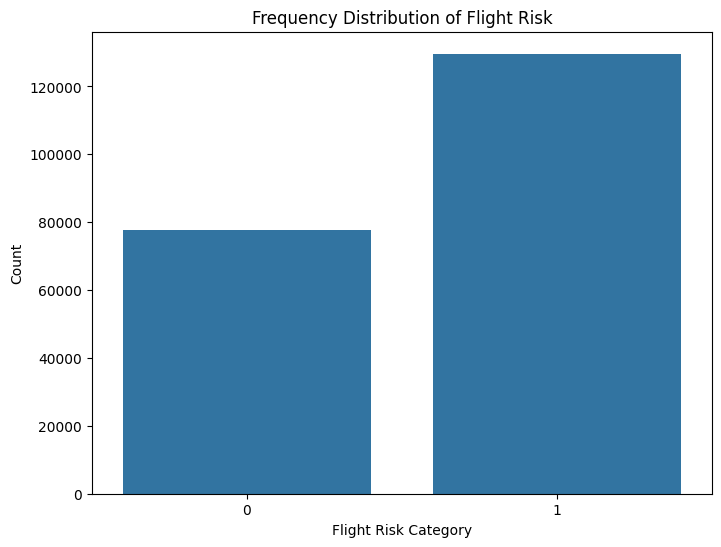

In [84]:
plt.figure(figsize=(8, 6))
sns.countplot(x='flight_risk', data=df)
plt.title('Frequency Distribution of Flight Risk')
plt.xlabel('Flight Risk Category')
plt.ylabel('Count')
plt.show()

# There is a moderate class imbalance, it is not severe so just play around with this to see if class_weight=balanced parameter improves model

**Encode categorical variables**

In [85]:
cat_cols = ['carrier', 'airport', 'covid_era']
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # save for inverse transform if needed

In [86]:
df.dtypes # Note that carrier_name and airport_name are the same as carrier and airport so we do not need to include them in the model

year                             int64
month                            int64
carrier                          int64
carrier_name                    object
airport                          int64
airport_name                    object
total_flights                  float64
on_time_pct                    float64
avg_delay_minutes              float64
carrier_delay_count            float64
weather_delay_count            float64
nas_delay_count                float64
security_delay_count           float64
late_aircraft_delay_count      float64
carrier_delay_minutes          float64
weather_delay_minutes          float64
nas_delay_minutes              float64
security_delay_minutes         float64
late_aircraft_delay_minutes    float64
cancellation_rate              float64
covid_era                        int64
flight_risk                      int64
dtype: object

In [87]:
# Save inverse transform just in case - this means you can switch back if you need to 
# The model does not need this, this is just a way to store information if we need it later on for presentation
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  

**Split training and testing based on time**

Few things to note here: 
- No CV will be added because that jumbles things up
- Splits will be time-based; train: Pre-COVID (2016–2019), test: COVID + Post-COVID (2020–2025)
    - This is because the COVID era is that nuanced shift in trends
- Year will be dropped (because it is already defined in the splits), carrier_name, and airport_name
- Month will be kept becuase it could provide some valuable information or general trends (summer vacation months vs off-season)
- Also remove on_time_pct, avg_delay_minutes, and cancellation_rate because they give the direct answer to the model and data leakage

In [88]:
train_df = df[df['year'] <= 2019]
test_df = df[df['year'] >= 2020]
X_train = train_df.drop(columns=['flight_risk', 'year', 'carrier_name', 'airport_name', 'on_time_pct', 'avg_delay_minutes', 'cancellation_rate'])
y_train = train_df['flight_risk']
X_test = test_df.drop(columns=['flight_risk', 'year', 'carrier_name', 'airport_name', 'on_time_pct', 'avg_delay_minutes', 'cancellation_rate'])
y_test = test_df['flight_risk']

**Training the Random Forest classifier (robust to outliers)**

In [89]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced") # Balance class weights
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Evaluate model**

In [90]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73     51353
           1       0.87      0.71      0.78     80475

    accuracy                           0.76    131828
   macro avg       0.76      0.77      0.75    131828
weighted avg       0.78      0.76      0.76    131828

ROC-AUC Score: 0.8448496568836716


Class weighting reduced bias toward the majority class and produced a more interpretable and operationally fair risk model. The balanced model improves recall for minority risk classes while maintaining strong overall discrimination (ROC-AUC ≈ 0.85), making it more reliable for operational risk monitoring.

**Test results for dashboard**

In [91]:
test_df = test_df.copy()
test_df['predicted_risk'] = y_pred
test_df['predicted_risk_prob'] = y_prob
test_df.to_csv("master_kpi_predictions.csv", index=False)

**ROC-AUC curve, confusion matrix, and feature importance for dashboard**

In [92]:
# Save roc-auc curve data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_df = pd.DataFrame({
    "false_positive_rate": fpr,
    "true_positive_rate": tpr,
    "threshold": thresholds})

roc_df.to_csv("roc_curve_data.csv", index=False)

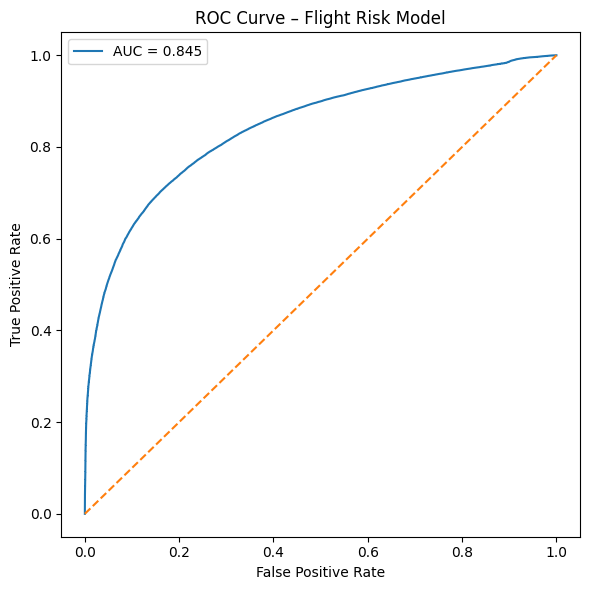

In [93]:
# Plot roc-auc curve
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Flight Risk Model")
plt.legend()
plt.tight_layout()
# plt.savefig("roc_curve.png")
# plt.close()

In [94]:
# Save feature importance
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importance.to_csv("feature_importance.csv", index=False)

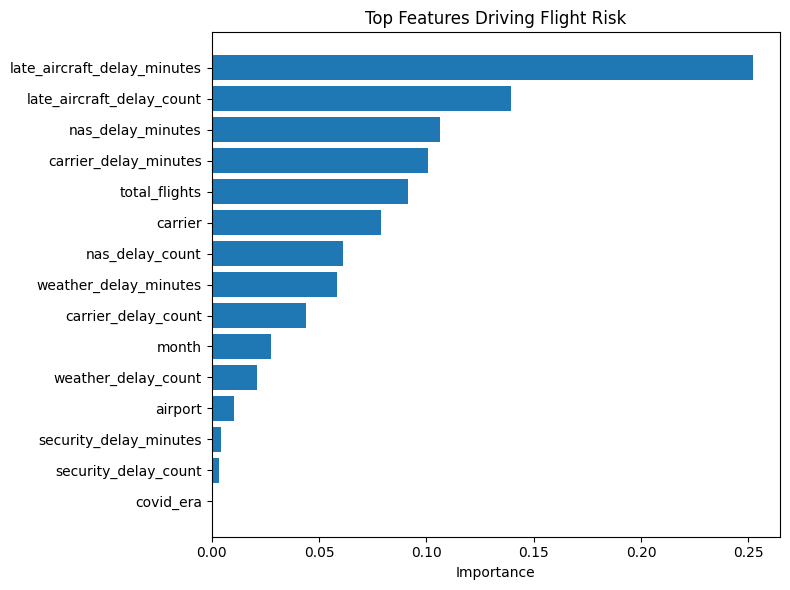

In [95]:
# Visualize feature importance
top_features = feature_importance.head(15) # top 15 features

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["feature"],
    top_features["importance"])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel("Importance")
plt.title("Top Features Driving Flight Risk")

plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

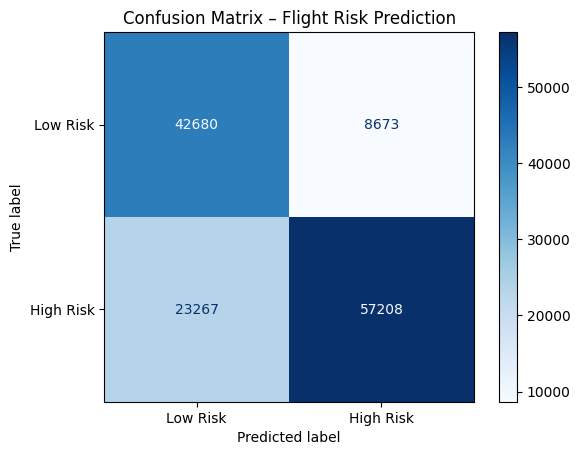

In [97]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Low Risk", "High Risk"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Flight Risk Prediction")
plt.show()

In [98]:
# Save confusion matrix
confusion_df = pd.DataFrame(
    cm,
    index=["Actual Low Risk", "Actual High Risk"],
    columns=["Predicted Low Risk", "Predicted High Risk"])

confusion_df.to_csv("confusion_matrix.csv")

### **Part 4: Create dashboard using data from KPI's #1-7**

Done on PowerBI.

**Adding longitude and latitude based on IATA codes**

In [4]:
airports=pd.read_csv("airport_latlon.csv")

In [5]:
df["airport"].unique()

array(['ABQ', 'ALB', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOI',
       'BOS', 'BUF', 'BWI', 'CHS', 'CLE', 'CLT', 'CMH', 'COS', 'DAY',
       'DCA', 'DEN', 'DFW', 'DSM', 'DTW', 'EGE', 'ELP', 'EWR', 'FAT',
       'FLL', 'GEG', 'GSO', 'GUC', 'HDN', 'HNL', 'HOU', 'IAD', 'IAH',
       'ICT', 'ILM', 'IND', 'JAC', 'JAX', 'JFK', 'KOA', 'LAS', 'LAX',
       'LBB', 'LGA', 'LIH', 'MCI', 'MCO', 'MDT', 'MEM', 'MFE', 'MIA',
       'MKE', 'MSP', 'MSY', 'MTJ', 'OAK', 'OGG', 'OKC', 'OMA', 'ONT',
       'ORD', 'ORF', 'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'PSP', 'PVD',
       'PWM', 'RDU', 'RIC', 'RNO', 'ROC', 'RSW', 'SAN', 'SAT', 'SDF',
       'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'STT',
       'STX', 'SYR', 'TPA', 'TUL', 'TUS', 'ADK', 'ADQ', 'BET', 'BLI',
       'BRW', 'BUR', 'CDV', 'FAI', 'JNU', 'KTN', 'OME', 'OTZ', 'PSG',
       'SCC', 'SIT', 'WRG', 'YAK', 'BQN', 'BTV', 'DAB', 'HPN', 'LGB',
       'ORH', 'PSE', 'SAV', 'SRQ', 'SWF', 'ABE', 'AGS', 'ATW', 'AVL',
       'AVP', 'BIL',

In [8]:
# Load master_kpi and airport lat/lon table
master_kpi = pd.read_csv("master_kpi.csv")
latlon = pd.read_csv("airport_latlon.csv")

# Drop duplicates in latlon so each IATA code is unique
latlon_clean = latlon.drop_duplicates(subset='IATA', keep='first')

# Merge only to get the IATA, Latitude, Longitude for the airports in master_kpi
latlon_for_master = master_kpi[['airport']].drop_duplicates().merge(
    latlon_clean[['IATA','Latitude','Longitude']],
    how='left',
    left_on='airport',
    right_on='IATA')

# Optional: check if any airports didn’t match
missing_coords = latlon_for_master[latlon_for_master['Latitude'].isnull()]
print("Airports with missing coordinates:")
print(missing_coords)

# Drop the redundant IATA column
latlon_for_master = latlon_for_master.drop(columns=['IATA'])

Airports with missing coordinates:
    airport IATA  Latitude  Longitude
200     ISN  NaN       NaN        NaN


ISN was replaced with X WA in 2019 so manually replace this.

In [9]:
latlon_for_master.to_csv("airport_latlon_cleaned.csv", index=False)

In [3]:
# Statistics
master_kpi = pd.read_csv("master_kpi.csv")
# Total delay minutes
master_kpi['total_delay_minutes'] = (
    master_kpi['carrier_delay_minutes'] +
    master_kpi['weather_delay_minutes'] +
    master_kpi['nas_delay_minutes'] +
    master_kpi['security_delay_minutes'] +
    master_kpi['late_aircraft_delay_minutes'])

# Contribution of late aircraft
master_kpi['late_aircraft_pct'] = master_kpi['late_aircraft_delay_minutes'] / master_kpi['total_delay_minutes']

# Example: average across all airports
avg_late_aircraft_pct = master_kpi['late_aircraft_pct'].mean()
print(f"Late aircraft delays contributed {avg_late_aircraft_pct:.2%} of total delay minutes")

Late aircraft delays contributed 34.69% of total delay minutes


In [4]:
pre_covid = master_kpi.loc[master_kpi['covid_era'] == 'Pre-COVID', 'on_time_pct'].mean()
during_covid = master_kpi.loc[master_kpi['covid_era'] == 'COVID', 'on_time_pct'].mean()
drop = pre_covid - during_covid

print(f"On-time performance dropped {drop:.2%} during COVID")

On-time performance dropped -5.48% during COVID


In [5]:
# Average delay minutes by COVID era
avg_delay_by_era = master_kpi.groupby('covid_era')['avg_delay_minutes'].mean()
print(avg_delay_by_era)

# Average cancellation rate by COVID era
avg_cancellation_by_era = master_kpi.groupby('covid_era')['cancellation_rate'].mean()
print(avg_cancellation_by_era)

covid_era
COVID          8.672356
Post-COVID    14.349687
Pre-COVID     12.707626
Name: avg_delay_minutes, dtype: float64
covid_era
COVID         0.045506
Post-COVID    0.018168
Pre-COVID     0.018462
Name: cancellation_rate, dtype: float64
